# Simulating pmax_lum and ec50_lum values to fit to a Sigmoid (or other) Curve for Lumefantrine Monotherapy

In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
from timeit import default_timer as timer
from matplotlib.ticker import MaxNLocator
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count

### ec50_lum range: 30 to 200
### Number of patients: 50k

In [2]:
# Define the range for ec50_lum
min_ec50 = 30
max_ec50 = 200

# Define pmax_art values
ec50_values = np.linspace(min_ec50, max_ec50, 50)  
ec50_values

# Initialize a grid to store the clearance rates
trial_efficacy = np.zeros(len(ec50_values))

In [3]:
def run_simulation(idx, ec50):
    command_ec50_lum_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "50000",
        "--pmax_art", "0",
        "--ec50_lum", str(ec50),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_ec50_lum = subprocess.run(command_ec50_lum_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_ec50_lum = output_ec50_lum.stdout.splitlines()
        df_ec50_lum = pd.DataFrame([line.split(',') for line in lines_ec50_lum], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_ec50_lum = df_ec50_lum.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_ec50_lum[(df_ec50_lum['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_ec50_lum['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for ec50_lum: {ec50}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {ec50}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, ec50_values[i]) for i in range(len(ec50_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    trial_efficacy[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'ec50_lum': ec50_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_lum_ec50_linear_01.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_lum_ec50_linear_01.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 50/50 [2:55:00<00:00, 210.01s/it]     

DataFrame saved as pickle and CSV files successfully.


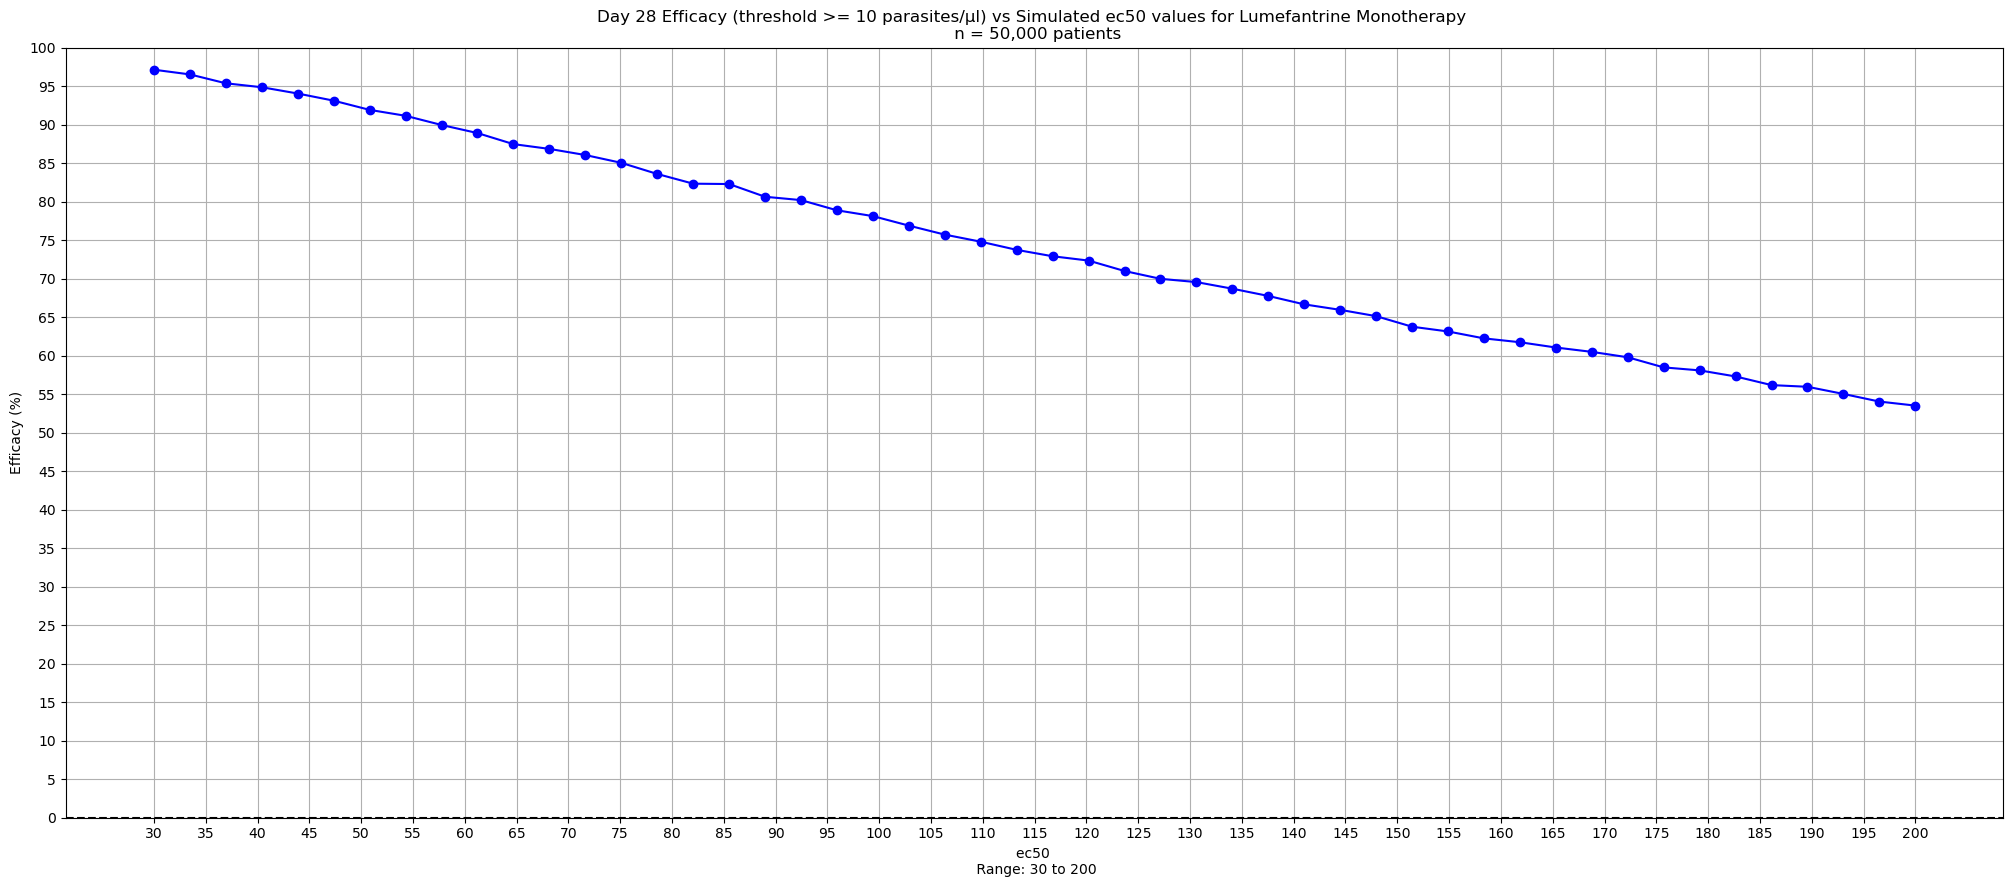

In [14]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(ec50_values, trial_efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('ec50 \n Range: 30 to 200')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated ec50 values for Lumefantrine Monotherapy \n n = 50,000 patients")
plt.grid(True)
plt.xticks(np.arange(min(ec50_values), max(ec50_values)+0.001, 5))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_lum_ec50_linear_01_prefit.png")  # Save the plot as a PNG file
plt.show()

In [2]:
import os
from scipy.optimize import curve_fit

#Checking if we are in the right directory to read the data
#If not set the working directory 
os.getcwd()
#os.chdir('/home/venitha_b/Projects/2019-test-ppq-pk/plots/AL/pkpd_AL/pfcrt.K76')

'/home/venitha_b/Projects/2019-test-ppq-pk/plots/AL/pkpd_AL/pfcrt+pfmdr1/bassat'

In [3]:
#Loading pmax and efficacy data
#os.listdir()
data = pd.read_csv('pkpd_AL_lum_ec50_linear_01.csv')
data.head()

,ec50_lum,efficacy
0,30.000000,97.118
1,33.469388,96.508
2,36.938776,95.354
3,40.408163,94.842
4,43.877551,94.026


In [8]:
# Linear function
def linear(x, m, b):
    y = (-m) * x + b
    return y

# Data
xdata = np.array(data['ec50_lum'])
ydata = np.array(data['efficacy'])

# Initial guess
m = 1
b = 5
popt = [m, b]

# Fit curve
popt, pcov = curve_fit(linear, xdata, ydata, popt, maxfev=10000)
fitted_values = linear(xdata, *popt)

print(f"m: {popt[0]}, b: {popt[1]}")


m: 0.2636513771583425, b: 104.63022837320939


In [9]:
# Function to extrapolate x given y
def extrapolate_x(y, m, b):
    # Solve for x
    x = (b - y) / m
    return x

# Example: Extrapolate x for a given y
y_target = 87  # Example efficacy value
x_target = extrapolate_x(y_target, *popt)

# Rescale to original x range
print(f"The value of x for y = {y_target} is approximately {x_target:.5f}")

The value of x for y = 87 is approximately 66.86947


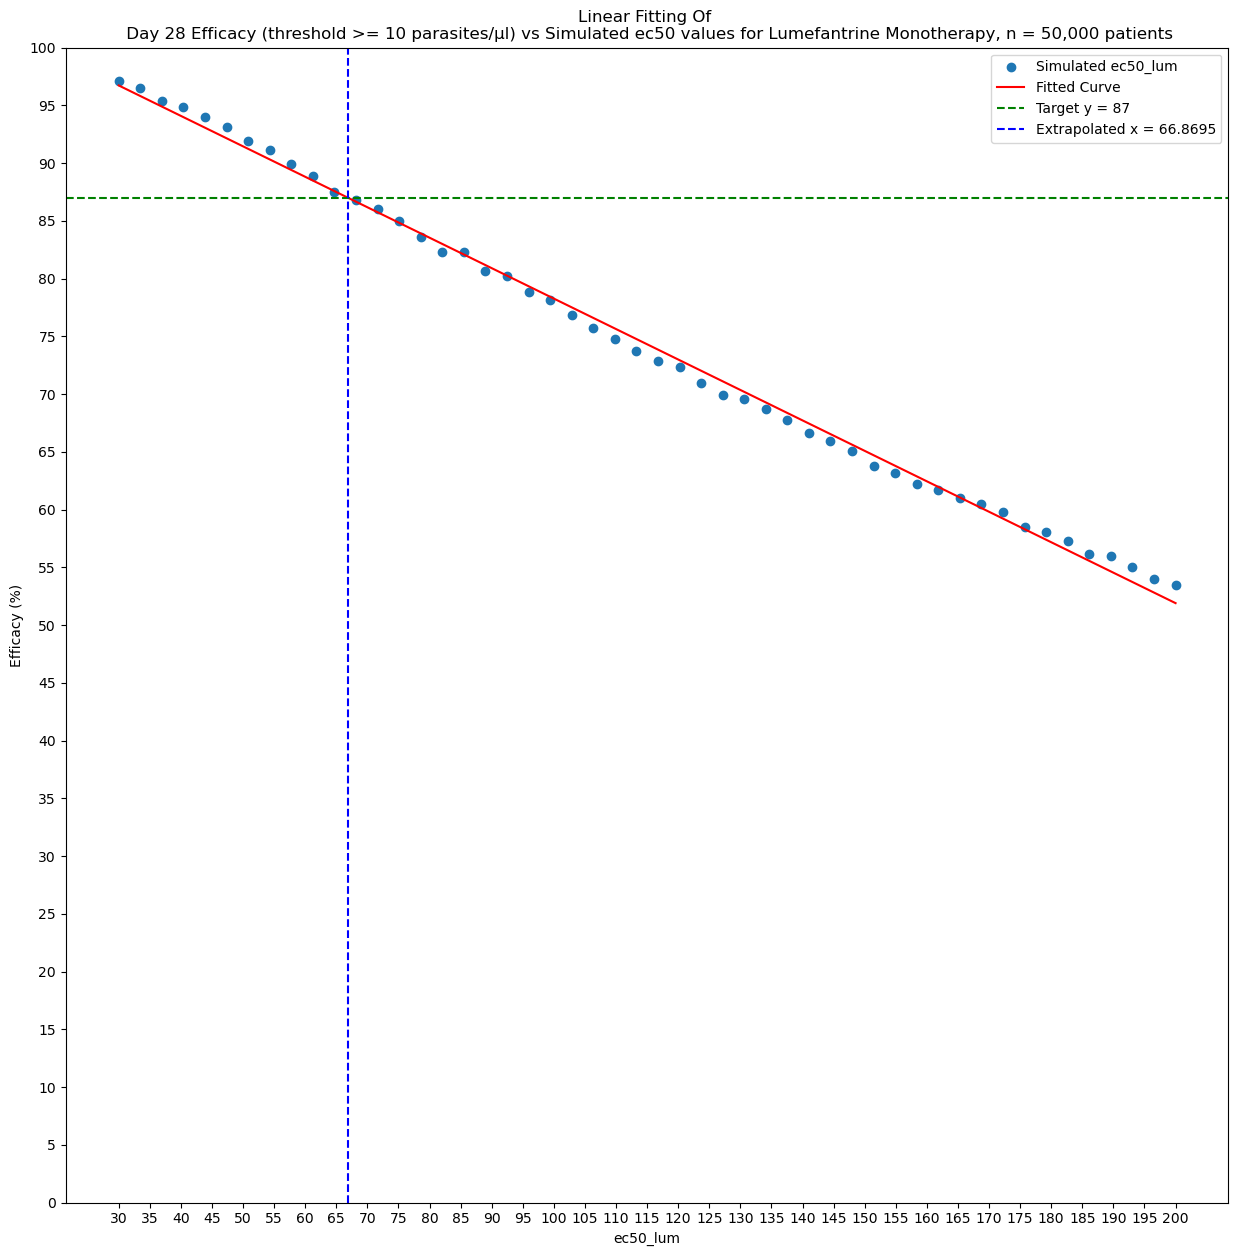

In [10]:
# Plot results
plt.figure(figsize=(15, 15))
plt.scatter(xdata, ydata, label='Simulated ec50_lum')
plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.axhline(y=y_target, color='green', linestyle='--', label=f'Target y = {y_target}')
plt.axvline(x=x_target, color='blue', linestyle='--', label=f'Extrapolated x = {x_target:.4f}')
plt.xticks(np.arange(min(xdata), max(xdata)+1, 5))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 105, 5))  # Y-axis ticks from 0 to 100%
plt.xlabel("ec50_lum")
plt.ylabel('Efficacy (%)')
plt.title("Linear Fitting Of \n Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated ec50 values for Lumefantrine Monotherapy, n = 50,000 patients")
plt.legend()
plt.savefig("pkpd_AL_lum_ec50_linear_01_postfit.png")
plt.show()

<br>

### pmax_lum range: 0.5 to 0.9995
### Number of patients: 50k

In [11]:
# Define the range for pmax_lum
min_pmax = 0.5
max_pmax = 0.9995

# Define pmax_art values
pmax_values = np.linspace(min_pmax, max_pmax, 50)  

# Initialize a grid to store the clearance rates
efficacy = np.zeros(len(pmax_values))

In [5]:
def run_simulation(idx, pmax):
    command_pmax_lum = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "50000",
        "--pmax_art", "0",
        "--pmax_lum", str(pmax),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_lum = subprocess.run(command_pmax_lum, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_lum = output_pmax_lum.stdout.splitlines()
        df_pmax_lum = pd.DataFrame([line.split(',') for line in lines_pmax_lum], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_pmax_lum = df_pmax_lum.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_lum[(df_pmax_lum['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_pmax_lum['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, eff in results:
    efficacy[idx] = eff

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_lum': pmax_values,
    'efficacy': efficacy
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_lum_pmax_linear_01.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_lum_pmax_linear_01.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 50/50 [3:04:00<00:00, 220.82s/it]     

DataFrame saved as pickle and CSV files successfully.


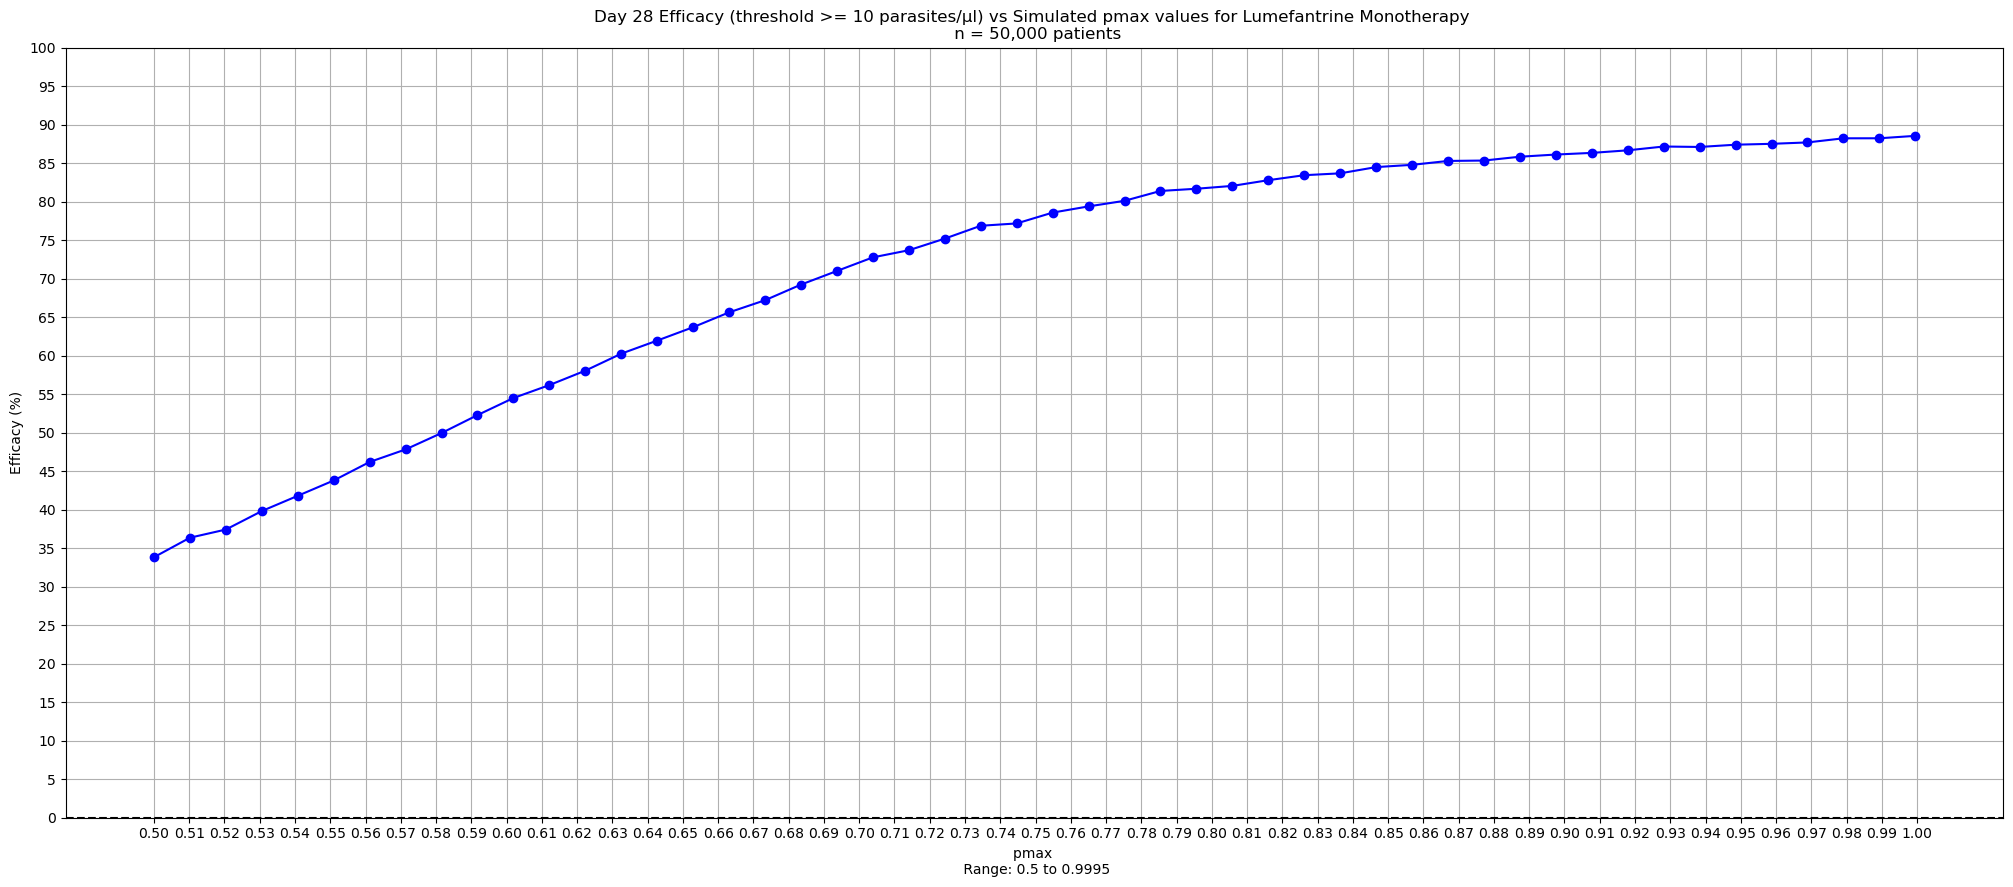

In [15]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('pmax \n Range: 0.5 to 0.9995')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Lumefantrine Monotherapy \n n = 50,000 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values)+0.001, 0.01))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_lum_pmax_linear_01_prefit.png")  # Save the plot as a PNG file
plt.show()

In [5]:
#Loading pmax and efficacy data
#os.listdir()
data = pd.read_csv('pkpd_AL_lum_pmax_linear_01.csv')
data.tail()

,pmax_lum,efficacy
45,0.958724,87.494
46,0.968918,87.674
47,0.979112,88.210
48,0.989306,88.214
49,0.999500,88.528


In [174]:
#Logarithmic function
def logarithmic_function(x, a, b, c):
    y = a * np.log(x - b) + c
    return y


# Data
xdata = np.array(data['pmax_lum'])
ydata = np.array(data['efficacy'])

# Initial guess
a = 25
b = 0.4
c = 10
p0 = [a, b, c]

# Fit curve
popt, pcov = curve_fit(logarithmic_function, xdata, ydata, p0, maxfev=10000)
fitted_values = logarithmic_function(xdata, *popt)

print(f"a: {popt[0]}", f"b: {popt[1]}", f"c: {popt[2]}")


a: 29.579747790074457 b: 0.4310282653818131 c: 108.9138371323014


In [10]:
import os
from scipy.optimize import curve_fit

def my_new_function(x, a, b, c):
    y = ((x - b)**a) + c
    return y

# Data
xdata = np.array(data['pmax_lum'])
ydata = np.array(data['efficacy'])

# Initial guess
a = 0.9
b = 0.01
c = 10
p0 = [a, b, c]

# Fit curve
popt, pcov = curve_fit(my_new_function, xdata, ydata, p0, maxfev=10000)
fitted_values = my_new_function(xdata, *popt)

print(f"a: {popt[0]}", f"b: {popt[1]}", f"c: {popt[2]}")


a: -200.90312406012225 b: -32.68310184119533 c: 71.0314


/tmp/ipykernel_15098/723742845.py:5: RuntimeWarning: invalid value encountered in power
  y = ((x - b)**a) + c
/tmp/ipykernel_15098/723742845.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(my_new_function, xdata, ydata, p0, maxfev=10000)


In [175]:
# Function to extrapolate x given y
def extrapolate_pmax(y, a, b, c):
    # Solve for x
    x = np.exp((y - c) / a) + b
    return x

# Example: Extrapolate x for a given y
y_target = 87  # Example efficacy value
x_target = extrapolate_pmax(y_target, *popt)

# Rescale to original x range
print(f"The value of x for y = {y_target} is approximately {x_target:.5f}")

The value of x for y = 87 is approximately 0.90774


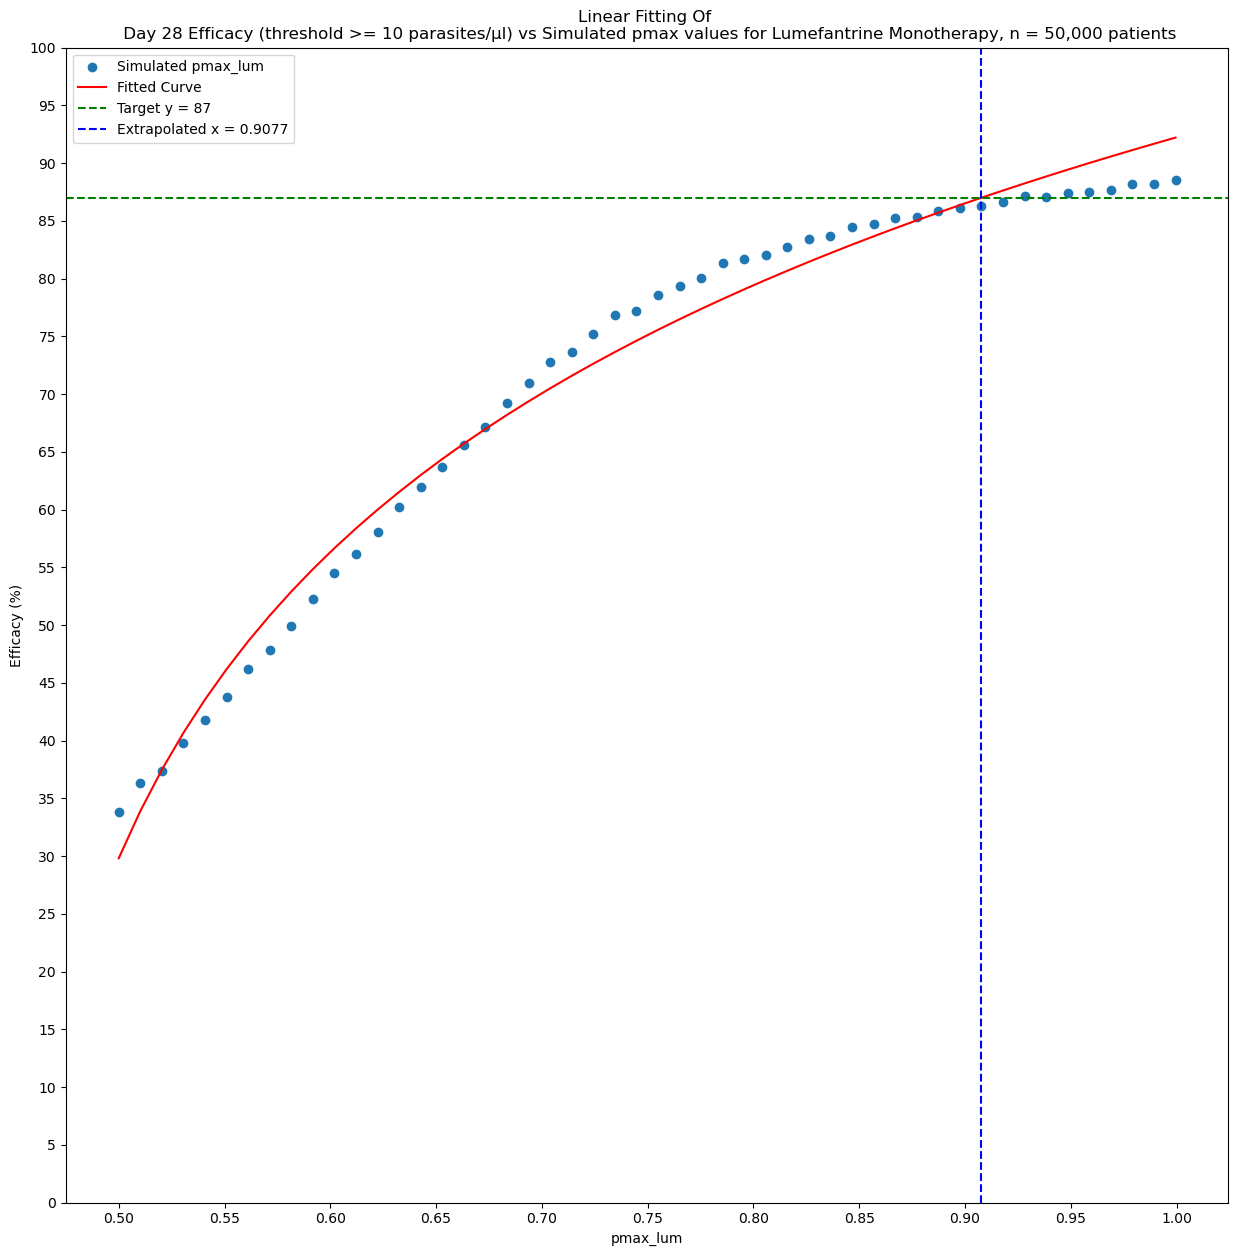

In [176]:
# Plot results
plt.figure(figsize=(15, 15))
plt.scatter(xdata, ydata, label='Simulated pmax_lum')
plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.axhline(y=y_target, color='green', linestyle='--', label=f'Target y = {y_target}')
plt.axvline(x=x_target, color='blue', linestyle='--', label=f'Extrapolated x = {x_target:.4f}')
plt.xticks(np.arange(min(xdata), max(xdata)+0.05, 0.05))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 105, 5))  # Y-axis ticks from 0 to 100%
plt.xlabel("pmax_lum")
plt.ylabel('Efficacy (%)')
plt.title("Linear Fitting Of \n Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Lumefantrine Monotherapy, n = 50,000 patients")
plt.legend()
plt.savefig("pkpd_AL_lum_pmax_logarithmic_e_01_postfit.png")
plt.show()

### Logarithmic function to the base 2

In [63]:
#Logarithmic function
def logarithmic_function_base2(x, a, b):
    y = a * np.log2(x) + b
    return y


# Data
xdata = np.array(data['pmax_lum'])
ydata = np.array(data['efficacy'])

# Initial guess
a = 1
b = 2
p0 = [a, b]

# Fit curve
popt, pcov = curve_fit(logarithmic_function_base2, xdata, ydata, p0, maxfev=10000)
fitted_values = logarithmic_function_base2(xdata, *popt)

print(f"a: {popt[0]}", f"b: {popt[1]}")


a: 56.327333735755 b: 96.05801600553815


In [64]:
# Function to extrapolate x given y
def extrapolate_pmax(y, a, b):
    # Solve for x
    x = 2**((y - b)/ a)
    return x

# Example: Extrapolate x for a given y
y_target = 87  # Example efficacy value
x_target = extrapolate_pmax(y_target, *popt)

# Rescale to original x range
print(f"The value of x for y = {y_target} is approximately {x_target:.5f}")

The value of x for y = 87 is approximately 0.89452


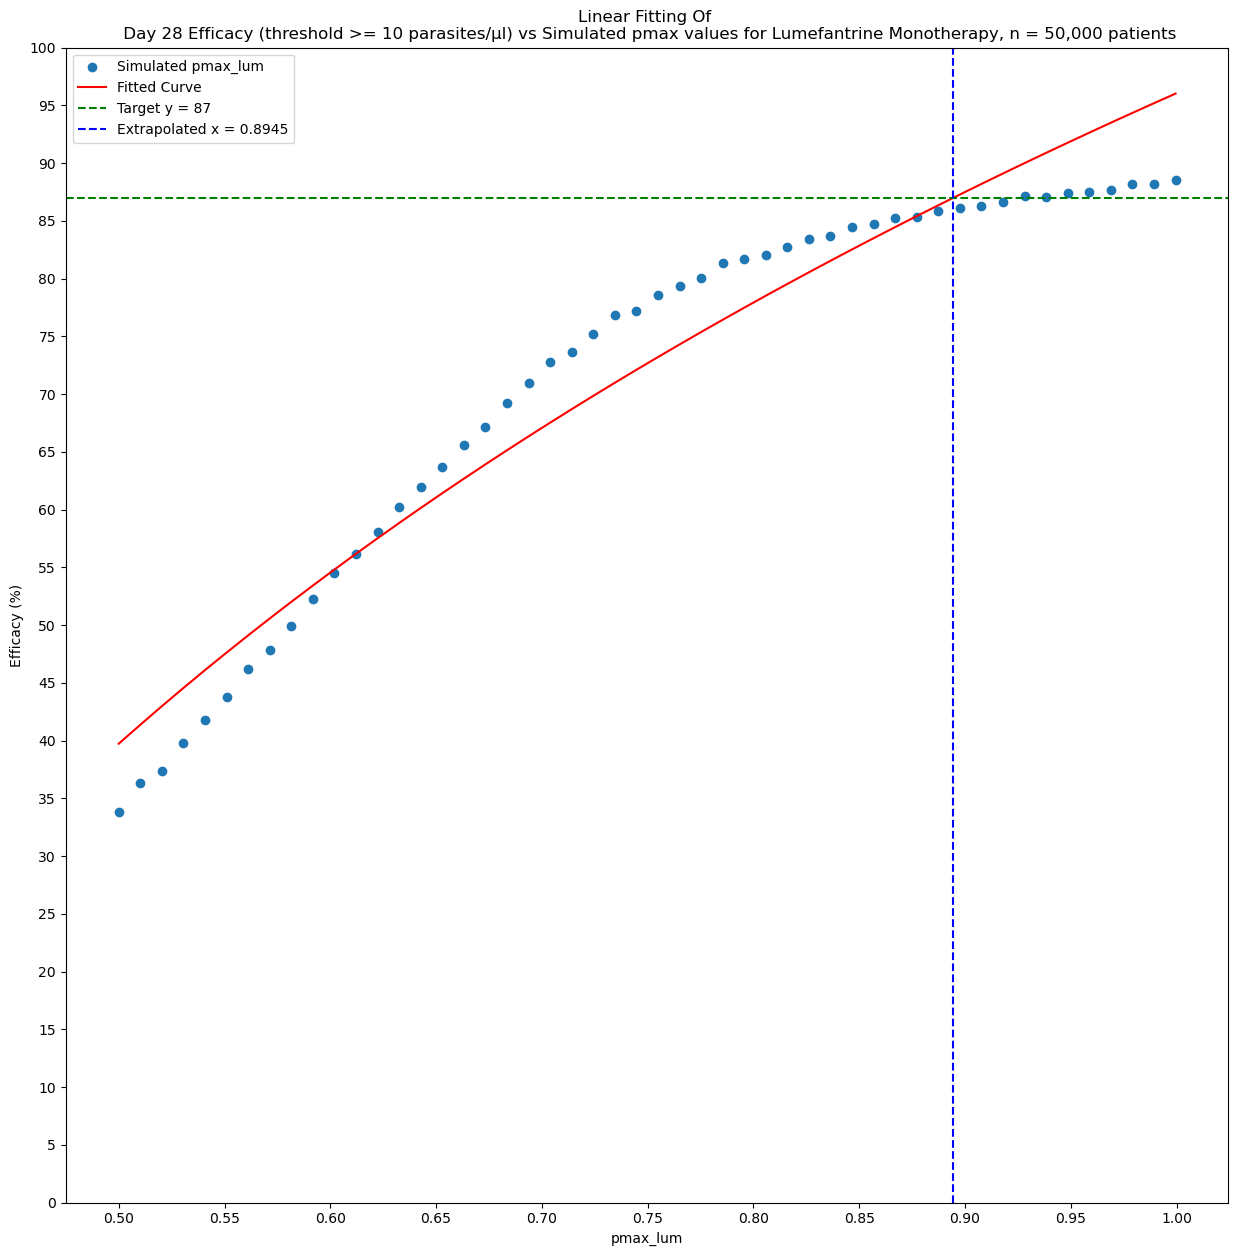

In [65]:
# Plot results
plt.figure(figsize=(15, 15))
plt.scatter(xdata, ydata, label='Simulated pmax_lum')
plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.axhline(y=y_target, color='green', linestyle='--', label=f'Target y = {y_target}')
plt.axvline(x=x_target, color='blue', linestyle='--', label=f'Extrapolated x = {x_target:.4f}')
plt.xticks(np.arange(min(xdata), max(xdata)+0.05, 0.05))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 105, 5))  # Y-axis ticks from 0 to 100%
plt.xlabel("pmax_lum")
plt.ylabel('Efficacy (%)')
plt.title("Linear Fitting Of \n Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Lumefantrine Monotherapy, n = 50,000 patients")
plt.legend()
plt.savefig("pkpd_AL_lum_pmax_logarithmic_02_postfit.png")
plt.show()

### Logarithmic function to the base 10

In [66]:
#Logarithmic function
def logarithmic_function_base10(x, a, b):
    y = a * np.log10(x) + b
    return y


# Data
xdata = np.array(data['pmax_lum'])
ydata = np.array(data['efficacy'])

# Initial guess
a = 1
b = 2
p0 = [a, b]

# Fit curve
popt, pcov = curve_fit(logarithmic_function_base10, xdata, ydata, p0, maxfev=10000)
fitted_values = logarithmic_function_base10(xdata, *popt)

print(f"a: {popt[0]}", f"b: {popt[1]}")


a: 187.1153522531216 b: 96.05801597795924


In [67]:
# Function to extrapolate x given y
def extrapolate_pmax(y, a, b):
    # Solve for x
    x = 10**((y - b)/ a)
    return x

# Example: Extrapolate x for a given y
y_target = 87  # Example efficacy value
x_target = extrapolate_pmax(y_target, *popt)

# Rescale to original x range
print(f"The value of x for y = {y_target} is approximately {x_target:.5f}")

The value of x for y = 87 is approximately 0.89452


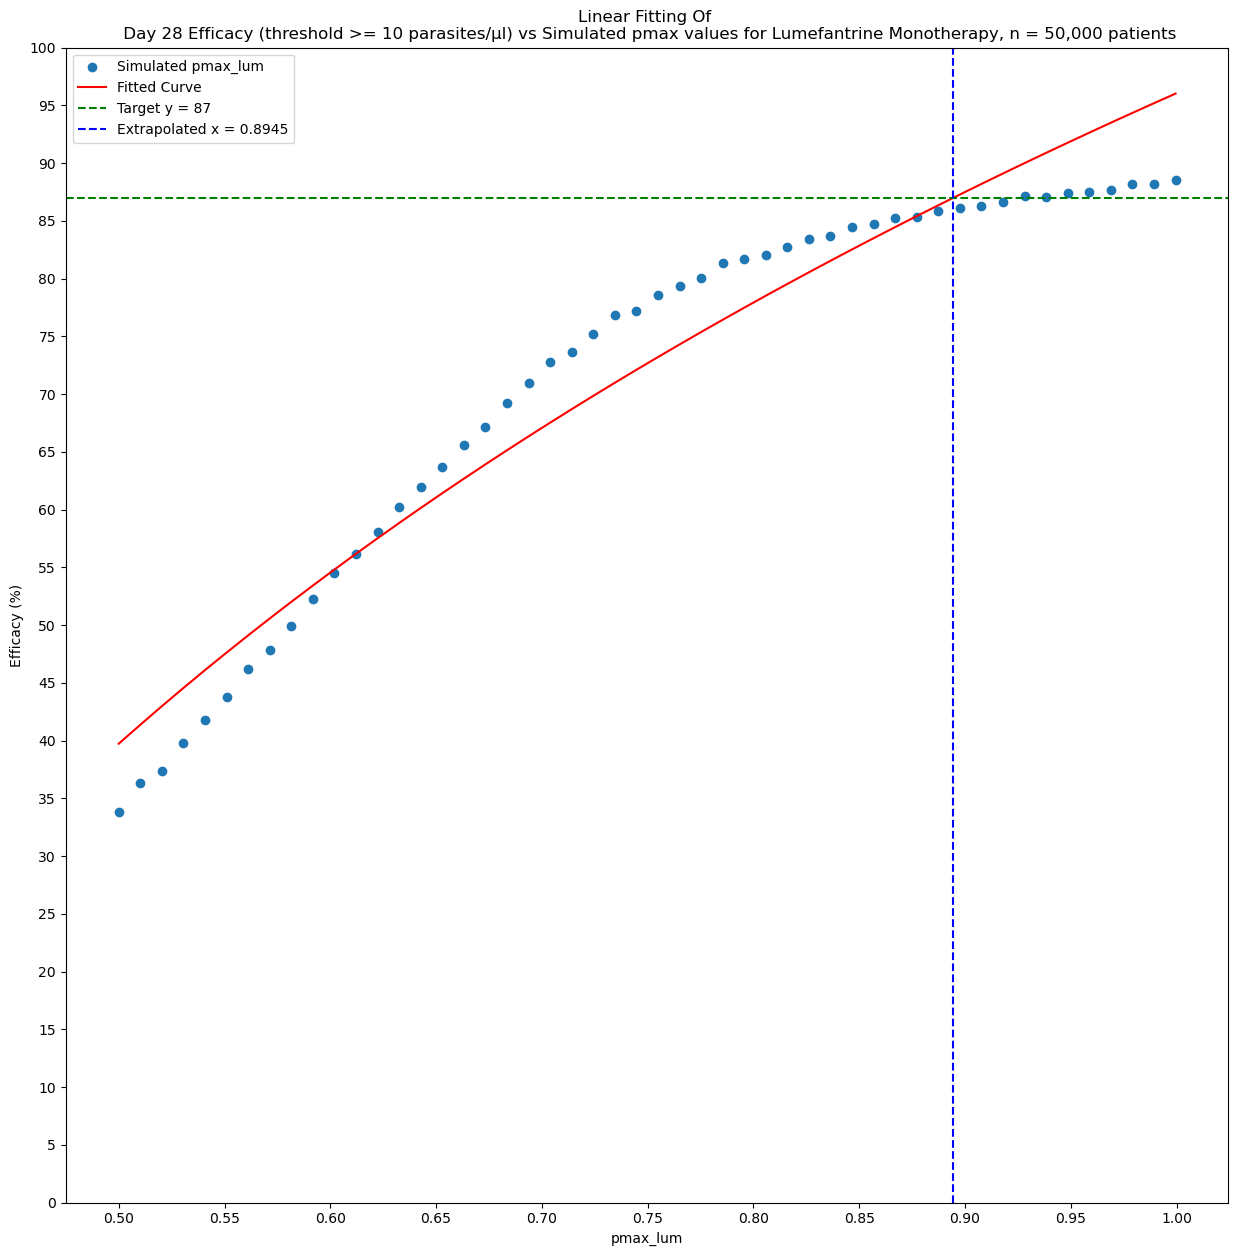

In [68]:
# Plot results
plt.figure(figsize=(15, 15))
plt.scatter(xdata, ydata, label='Simulated pmax_lum')
plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.axhline(y=y_target, color='green', linestyle='--', label=f'Target y = {y_target}')
plt.axvline(x=x_target, color='blue', linestyle='--', label=f'Extrapolated x = {x_target:.4f}')
plt.xticks(np.arange(min(xdata), max(xdata)+0.05, 0.05))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 105, 5))  # Y-axis ticks from 0 to 100%
plt.xlabel("pmax_lum")
plt.ylabel('Efficacy (%)')
plt.title("Linear Fitting Of \n Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Lumefantrine Monotherapy, n = 50,000 patients")
plt.legend()
plt.savefig("pkpd_AL_lum_pmax_logarithmic_10_postfit.png")
plt.show()

In [2]:
# Define the range for pmax_lum
min_pmax = 0.5
max_pmax = 0.9995

# Define pmax_art values
pmax_values = np.linspace(min_pmax, max_pmax, 50)  

# Initialize a grid to store the clearance rates
efficacy = np.zeros(len(pmax_values))

In [3]:
def run_simulation(idx, pmax):
    command_pmax_lum = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "50000",
        "--pmax_art", "0",
        "--ec50_lum", "66.8695",
        "--pmax_lum", str(pmax),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_lum = subprocess.run(command_pmax_lum, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_lum = output_pmax_lum.stdout.splitlines()
        df_pmax_lum = pd.DataFrame([line.split(',') for line in lines_pmax_lum], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_pmax_lum = df_pmax_lum.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_lum[(df_pmax_lum['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_pmax_lum['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, eff in results:
    efficacy[idx] = eff

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_lum': pmax_values,
    'efficacy': efficacy
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_lum_pmax_linear_02.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_lum_pmax_linear_02.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 50/50 [3:17:55<00:00, 237.51s/it]     

DataFrame saved as pickle and CSV files successfully.


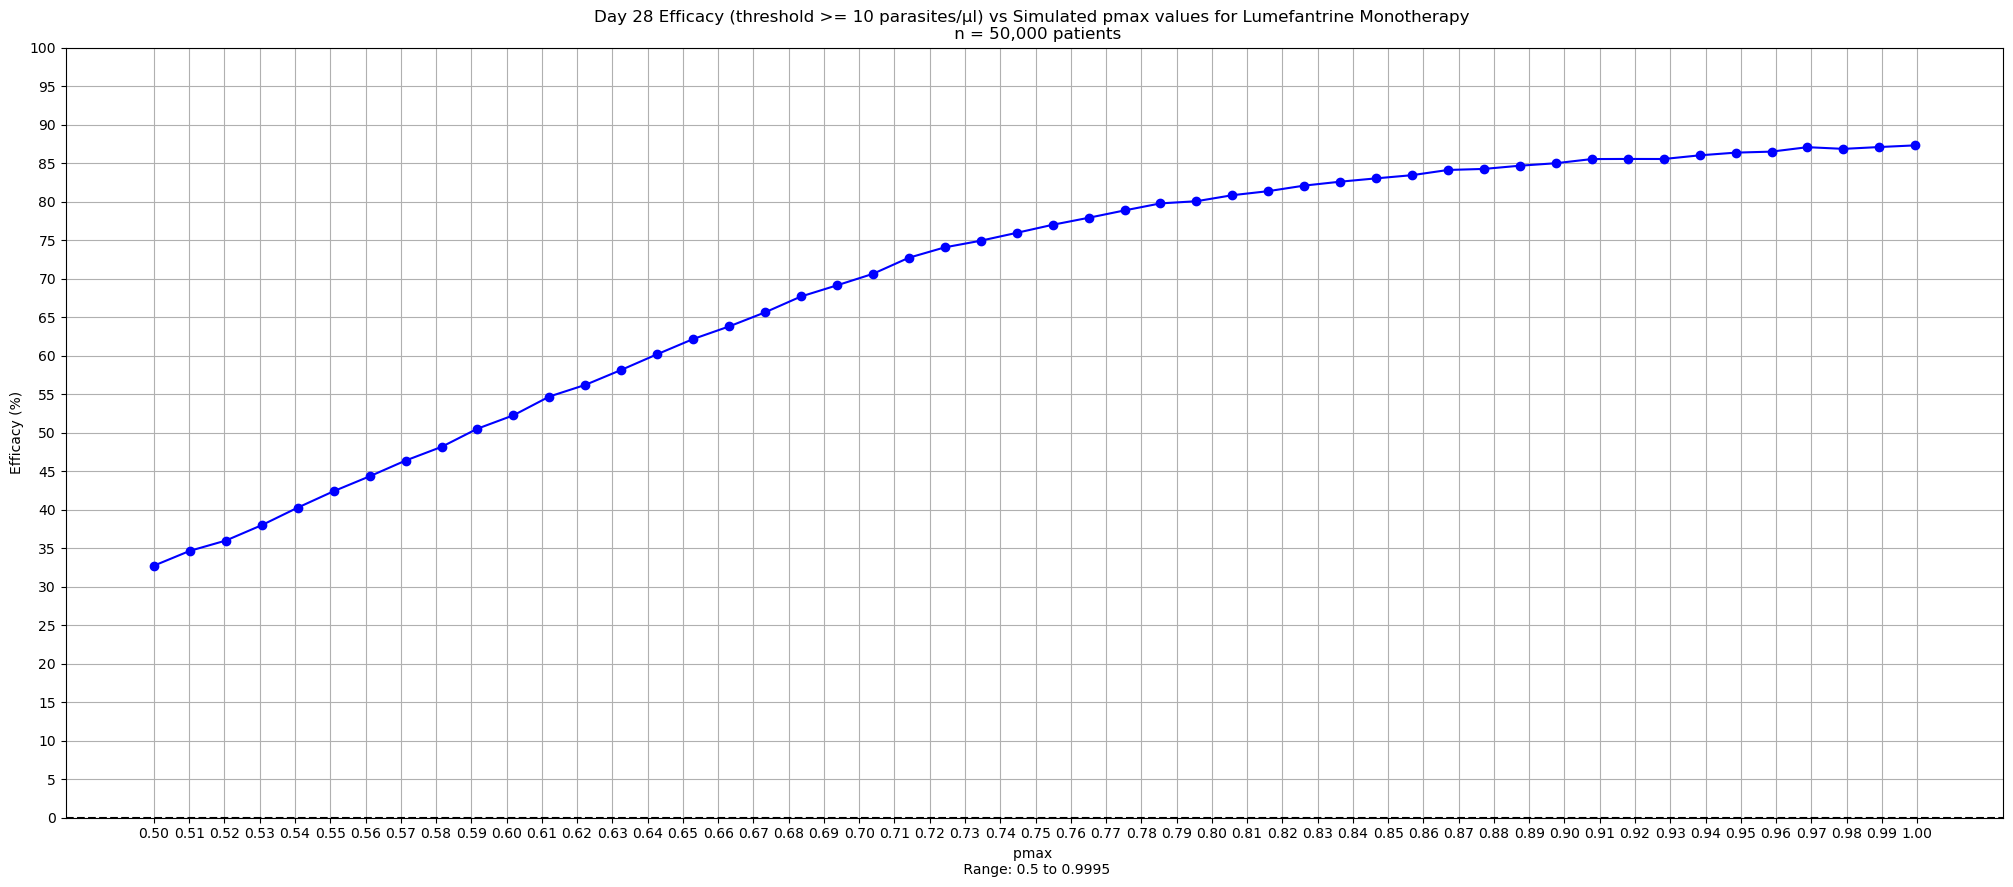

In [5]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('pmax \n Range: 0.5 to 0.9995')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Lumefantrine Monotherapy \n n = 50,000 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values)+0.001, 0.01))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_lum_pmax_logistic_e_02_prefit.png")  # Save the plot as a PNG file
plt.show()

In [9]:
import os
from scipy.optimize import curve_fit

#Logarithmic function
def logarithmic_function(x, a, b, c):
    y = a * np.log(x - b) + c
    return y


# Data
xdata = np.array(df['pmax_lum'])
ydata = np.array(df['efficacy'])

# Initial guess
a = 25
b = 0.4
c = 10
p0 = [a, b, c]

# Fit curve
popt, pcov = curve_fit(logarithmic_function, xdata, ydata, p0, maxfev=10000)
fitted_values = logarithmic_function(xdata, *popt)

print(f"a: {popt[0]}", f"b: {popt[1]}", f"c: {popt[2]}")


a: 30.695498506098875 b: 0.42557831807351215 c: 108.19301189161973


In [11]:
# Function to extrapolate x given y
def extrapolate_pmax(y, a, b, c):
    # Solve for x
    x = np.exp((y - c) / a) + b
    return x

# Example: Extrapolate x for a given y
y_target = 87  # Example efficacy value
x_target = extrapolate_pmax(y_target, *popt)

# Rescale to original x range
print(f"The value of x for y = {y_target} is approximately {x_target:.5f}")

The value of x for y = 87 is approximately 0.92694


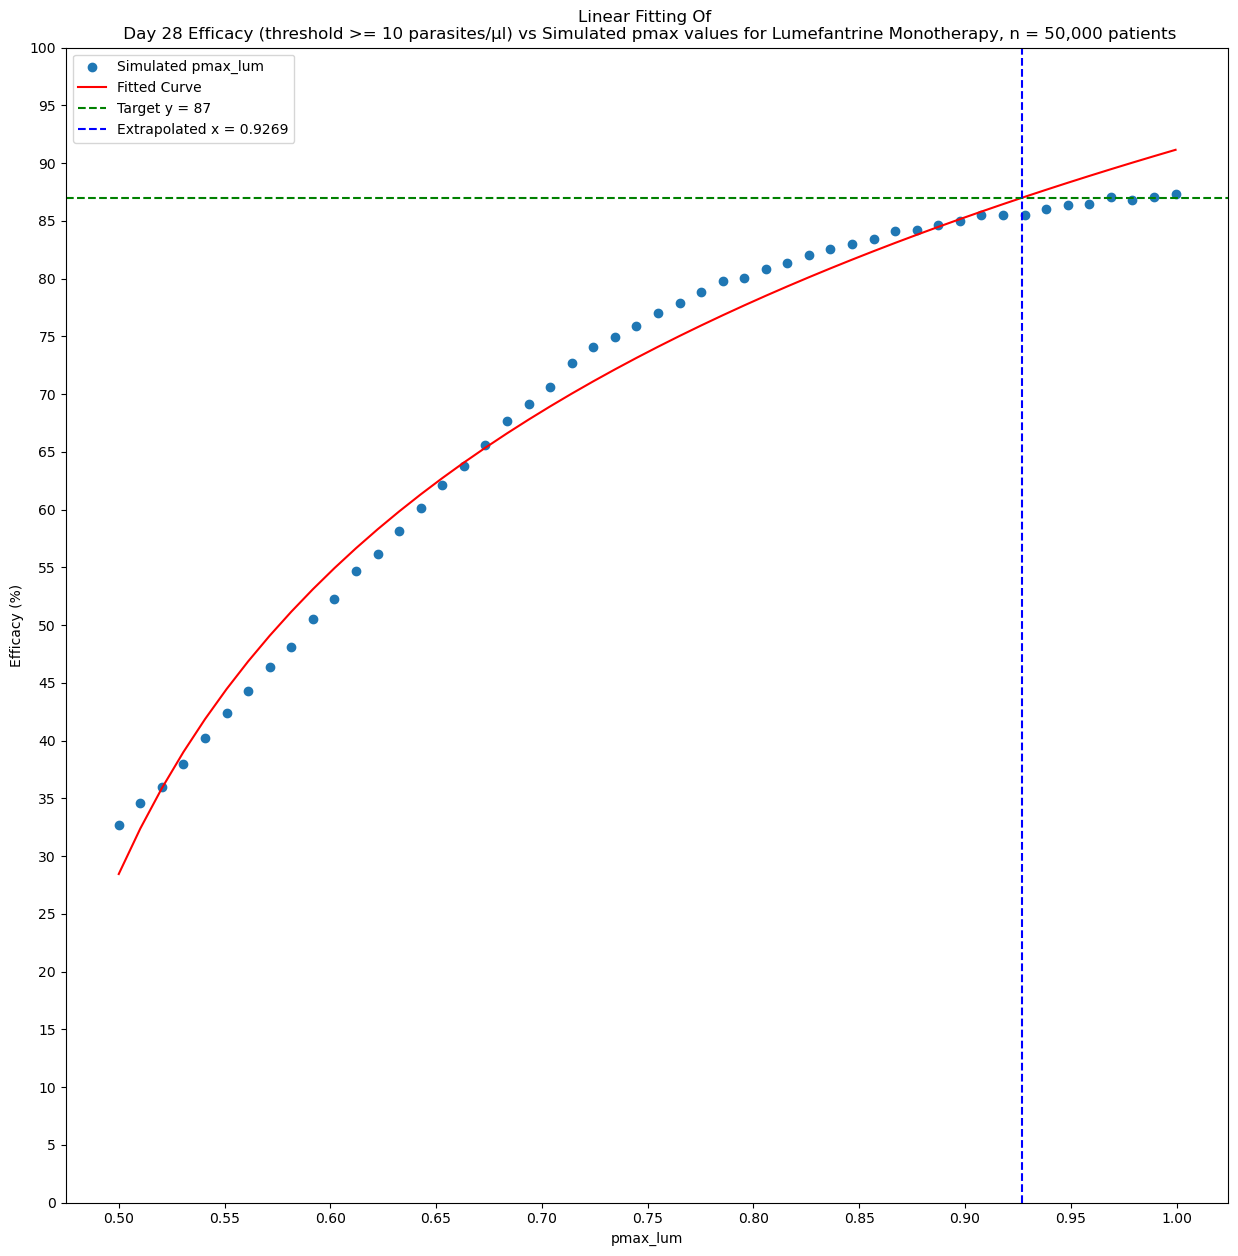

In [12]:
# Plot results
plt.figure(figsize=(15, 15))
plt.scatter(xdata, ydata, label='Simulated pmax_lum')
plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.axhline(y=y_target, color='green', linestyle='--', label=f'Target y = {y_target}')
plt.axvline(x=x_target, color='blue', linestyle='--', label=f'Extrapolated x = {x_target:.4f}')
plt.xticks(np.arange(min(xdata), max(xdata)+0.05, 0.05))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 105, 5))  # Y-axis ticks from 0 to 100%
plt.xlabel("pmax_lum")
plt.ylabel('Efficacy (%)')
plt.title("Linear Fitting Of \n Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Lumefantrine Monotherapy, n = 50,000 patients")
plt.legend()
plt.savefig("pkpd_AL_lum_pmax_logarithmic_e_02_postfit.png")
plt.show()